<a href="https://colab.research.google.com/github/Jaquelinedops/Benchmarking_NER/blob/main/trustmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
#TESTE DE STRESS - ESTEGANOGRAFIA

1.   TrustMark
2.   DCT


```



In [ ]:
!pip install torch==2.1.2+cu121 torchvision==0.16.2+cu121 -f https://download.pytorch.org/whl/torch_stable.html
!pip install sewar
!pip install scikit-image
!pip install trustmark
!pip install pytorch-msssim

In [ ]:
# Passo 1: Desinstala as bibliotecas de forma forçada para evitar conflitos
print("Desinstalando PyTorch e TrustMark para uma instalação limpa...")
!pip uninstall trustmark -y
!pip uninstall torch torchvision torchaudio -y

# Passo 2: Instala a versão mais recente e compatível do PyTorch para CUDA
# O --index-url garante que a versão correta da GPU seja instalada.
print("\nReinstalando a versão mais recente do PyTorch...")
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Passo 3: Reinstala o TrustMark. Agora, ele terá o PyTorch compatível.
print("\nReinstalando TrustMark...")
!pip install trustmark

# Passo 4: Verificação final
print("\nVerificação de versão...")
import torch
import trustmark

print(f"Versão do PyTorch instalada: {torch.__version__}")
print(f"TrustMark importado com sucesso!")

In [ ]:
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim
from sewar.full_ref import vifp
import os
import time
import torch

print("Is CUDA available?:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Total VRAM:", round(torch.cuda.get_device_properties(0).total_memory / 1024**3, 2), "GB")
else:
    print("CUDA not available. GPU not detected.")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Is CUDA available?: True
GPU Name: NVIDIA A100-SXM4-40GB
Total VRAM: 39.56 GB
Using device: cuda


#Utilitários


*   calculate_mse - Calcula o Mean Square erro entre duas imagens
*   calculate_ssim - Structural Similarity Index (SSIM)
*   calculate_vif -



In [ ]:
!pip install numpy

In [ ]:
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim
from sewar.full_ref import vifp
import os
import time
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando o dispositivo: {device}")
def calculate_mse(image_path1, image_path2):
    """
    Calculates the Mean Squared Error (MSE) between two images given their paths.

    Args:
        image_path1 (str): Path to the first image.
        image_path2 (str): Path to the second image.

    Returns:
        float: The MSE value, or None if an error occurs.
    """
    try:
        img1 = Image.open(image_path1).convert('RGB')
        img2 = Image.open(image_path2).convert('RGB')
    except FileNotFoundError:
        print(f"Error: One or both image files not found: {image_path1}, {image_path2}")
        return None
    except Exception as e:
        print(f"An error occurred while opening images: {e}")
        return None

    np_img1 = np.array(img1)
    np_img2 = np.array(img2)

    if np_img1.shape != np_img2.shape:
        print("Error: Images must have the same dimensions for MSE calculation.")
        return None

    err = np.sum((np_img1.astype("float") - np_img2.astype("float")) ** 2)
    err /= float(np_img1.shape[0] * np_img1.shape[1])
    return err

def calculate_ssim(image_path1, image_path2):
    """
    Calculates the Structural Similarity Index (SSIM) between two images
    given their paths. Images are converted to grayscale for SSIM calculation.

    Args:
        image_path1 (str): Path to the first image.
        image_path2 (str): Path to the second image.

    Returns:
        float: The SSIM value, or None if an error occurs.
    """
    try:
        img1 = Image.open(image_path1).convert('L')  # Convert to grayscale
        img2 = Image.open(image_path2).convert('L')  # Convert to grayscale
    except FileNotFoundError:
        print(f"Error: One or both image files not found: {image_path1}, {image_path2}")
        return None
    except Exception as e:
        print(f"An error occurred while opening images: {e}")
        return None

    np_img1 = np.array(img1)
    np_img2 = np.array(img2)

    if np_img1.shape != np_img2.shape:
        print("Error: Images must have the same dimensions for SSIM calculation.")
        return None

    ssim_value = ssim(np_img1, np_img2)
    return ssim_value



# --- Novas funções para FSIM e VIF ---
def calculate_fsim(image_path1, image_path2):
    """
    Calculates the Feature Similarity Index (FSIM) between two images given their paths.
    Requires images to be in RGB format.
    FSIM typically ranges from 0 to 1, where 1 indicates perfect similarity.
    """
    try:
        img1 = Image.open(image_path1).convert('RGB')
        img2 = Image.open(image_path2).convert('RGB')
    except FileNotFoundError:
        print(f"Error: One or both image files not found for FSIM: {image_path1}, {image_path2}")
        return None
    except Exception as e:
        print(f"An error occurred while opening images for FSIM: {e}")
        return None

    np_img1 = np.array(img1)
    np_img2 = np.array(img2)

    if np_img1.shape != np_img2.shape:
        print("Error: Images must have the same dimensions for FSIM calculation.")
        return None

    # fsim function in sewar expects images as NumPy arrays
    # It returns FSIM value and the Phase Congruency (PC) map, we only need the FSIM value
    fsim_value, _ = sewar.full_ref.fsim(np_img1, np_img2) # full=True makes it return PC map too, but not needed for value
    return fsim_value


def calculate_vif(image_path1, image_path2):
    """
    Calculates the Visual Information Fidelity (VIFp) between two images given their paths.
    Requires images to be in RGB format.
    VIF values are typically non-negative, with higher values indicating better visual fidelity.
    """
    try:
        img1 = Image.open(image_path1).convert('RGB')
        img2 = Image.open(image_path2).convert('RGB')
    except FileNotFoundError:
        print(f"Error: One or both image files not found for VIF: {image_path1}, {image_path2}")
        return None
    except Exception as e:
        print(f"An error occurred while opening images for VIF: {e}")
        return None

    np_img1 = np.array(img1)
    np_img2 = np.array(img2)

    if np_img1.shape != np_img2.shape:
        print("Error: Images must have the same dimensions for VIF calculation.")
        return None

    vif_value = vifp(np_img1, np_img2)
    return vif_value

def get_similarity_metrics(technique_name, image_path1, image_path2):
    """
    Calculates and returns a tuple of (technique_name, mse_value, ssim_value, fsim_value, vif_value)
    for two given image paths. Prints details about the comparison.
    NOTE: FSIM will be None as it's not directly available in used libraries.
    """
    print(f"\n--- Calculando métricas para: {technique_name} entre '{image_path1}' e '{image_path2}' ---")

    mse_value = calculate_mse(image_path1, image_path2)
    ssim_value = calculate_ssim(image_path1, image_path2)
    fsim_value = None # Set FSIM to None, as it's not directly calculated here
    vif_value = calculate_vif(image_path1, image_path2)

    print(f"  MSE: {mse_value:.4f}" if mse_value is not None else "  MSE: N/A")
    print(f"  SSIM: {ssim_value:.4f}" if ssim_value is not None else "  SSIM: N/A")
    print(f"  FSIM: {fsim_value:.4f}" if fsim_value is not None else "  FSIM: N/A (Not available in this setup)")
    print(f"  VIF: {vif_value:.4f}" if vif_value is not None else "  VIF: N/A")
    print("-" * 60)

    print("\n--- Interpretação das Métricas Perceptuais ---")
    print("Essas métricas buscam correlacionar-se melhor com a percepção humana da qualidade e similaridade da imagem:")
    print("- **SSIM**: Excelente para capturar a estrutura, contraste e luminância.")
    print("- **FSIM**: Foca em características de baixo nível que o sistema visual humano é bom em detectar (gradientes de fase e magnitude).")
    print("- **VIFp**: Modela como a informação é extraída pelo sistema visual humano, avaliando a fidelidade da informação visual.")
    print("=" * 70)

    return (technique_name, mse_value, ssim_value, fsim_value, vif_value)

def compare_images(image_path1, image_path2, tecnique_name="Your_model"):
    """
    Compares two images using MSE and SSIM, and prints the results with interpretation.

    Args:
        image_path1 (str): Path to the first image.
        image_path2 (str): Path to the second image.
    """
    print(f"Comparing '{image_path1}' and '{image_path2}':")
    print("-" * 30)
    # Calculate MSE
    mse_value = calculate_mse(image_path1, image_path2)
    if mse_value is not None:
        print(f"Mean Squared Error (MSE): {mse_value:.2f}")
    else:
        print("Could not calculate MSE due to an error.")

    # Calculate SSIM
    ssim_value = calculate_ssim(image_path1, image_path2)
    if ssim_value is not None:
        print(f"Structural Similarity Index (SSIM): {ssim_value:.2f}")
    else:
        print("Could not calculate SSIM due to an error.")

 # Calculate FSIM
    fsim_value = calculate_fsim(image_path1, image_path2)
    if fsim_value is not None:
        print(f"Feature Similarity Index (FSIM): {fsim_value:.4f}")
    else:
        print("  * Não foi possível calcular o FSIM devido a um erro.")

    print("-" * 60)

    # Calculate VIF
    vif_value = calculate_vif(image_path1, image_path2)
    if vif_value is not None:
        print(f"Visual Information Fidelity (VIFp): {vif_value:.4f}")
    else:
        print("  * Não foi possível calcular o VIFp devido a um erro.")

    return (tecnique_name, mse_value, ssim_value, fsim_value, vif_value)

def print_metrics_table():
    """
    Imprime uma tabela explicativa sobre as métricas de similaridade de imagem,
    indicando o que medem, o valor ideal e sua interpretação.
    """
    print("--- Entendendo as Métricas de Similaridade de Imagem ---")
    print("\nAo avaliar a similaridade entre duas imagens, especialmente após processos como compressão ou esteganografia, usamos métricas para quantificar o quão parecidas elas são. Algumas dessas métricas focam na diferença exata de pixels, enquanto outras tentam imitar a percepção humana.\n")

    # Cabeçalho da tabela
    header = f"{'Métrica':<10} | {'O que mede':<50} | {'Valor ideal':<15} | {'Interpretação do valor':<50}"
    separator = "-" * len(header)

    print(header)
    print(separator)

    # Dados das métricas
    metrics_data = [
        ("MSE", "Erro médio quadrático (diferença pixel a pixel)", "Menor", "0 = Imagens idênticas. Maior = Menos similar."),
        ("SSIM", "Similaridade estrutural, contraste, luminância (perceptual)", "Maior", "1 = Perfeitamente similar (perceptual). Próximo de 1 = Alta similaridade."),
        ("VIFp", "Fidelidade da informação visual (perceptual)", "Maior", "Quanto maior, mais informação visual da original foi retida."),
        ("FSIM", "Similaridade de características visuais (perceptual)", "Maior", "1 = Similaridade de características perfeita. Próximo de 1 = Alta similaridade.")
    ]

    # Imprimir as linhas da tabela
    for metric, description, ideal_value, interpretation in metrics_data:
        # Quebrar a descrição se for muito longa para manter o alinhamento
        # Isso é uma simplificação; para quebras de linha complexas, seria necessário um algoritmo mais robusto
        if len(description) > 50:
            desc_lines = [description[i:i+50] for i in range(0, len(description), 50)]
            print(f"{metric:<10} | {desc_lines[0]:<50} | {ideal_value:<15} | {interpretation:<50}")
            for i in range(1, len(desc_lines)):
                print(f"{'':<10} | {desc_lines[i]:<50} | {'':<15} | {'':<50}")
        else:
            print(f"{metric:<10} | {description:<50} | {ideal_value:<15} | {interpretation:<50}")

    print(separator)
    print("\nEscolher a métrica certa depende do seu objetivo. Para qualidade perceptual, **SSIM**, **VIFp** e **FSIM** são geralmente mais relevantes que o **MSE**.")



def display_image_if_exists(image_path, title="Imagem"):
    """
    Attempts to load and display an image at the given path using matplotlib.
    If the image file does not exist, it prints a message and does nothing else.

    Args:
        image_path (str): The full path to the image file (e.g., 'path/to/my_image.png').
        title (str, optional): The title to display above the image. Defaults to "Imagem".
    """
    if not os.path.exists(image_path):
        print(f"Erro: A imagem '{image_path}' não foi encontrada. Não é possível exibir.")
        return

    # Visualize the image
    try:
        current_img = Image.open(image_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(current_img)
        plt.title(title)
        plt.axis('off') # Hide axes for cleaner image display
        plt.show()
    except Exception as e:
        print(f"Não foi possível carregar ou exibir a imagem '{image_path}': {e}")


import os
from PIL import Image, ImageChops # ImageChops for color operations
import matplotlib.pyplot as plt
from trustmark import TrustMark # Assuming TrustMark is installed and accessible


# --- Helper Function to Display Images (from previous interactions) ---
def display_image_if_exists(image_path, title="Imagem"):
    if not os.path.exists(image_path):
        print(f"Erro: A imagem '{image_path}' não foi encontrada. Não é possível exibir.")
        return

    try:
        current_img = Image.open(image_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(current_img)
        plt.title(title)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Não foi possível carregar ou exibir a imagem '{image_path}': {e}")

# --- Attack Functions ---

def attack_resize(input_pil_image, output_path, percentage):
    """Resizes the image by a given percentage."""
    width, height = input_pil_image.size
    new_width = int(width * percentage / 100)
    new_height = int(height * percentage / 100)
    resized_img = input_pil_image.resize((new_width, new_height), Image.LANCZOS) # LANCZOS for high quality downsampling
    resized_img.save(output_path)
    return resized_img

def attack_rotate(input_pil_image, output_path, angle):
    """Rotates the image by a given angle."""
    # Expand=True to ensure the entire rotated image is visible,
    # fillcolor for empty areas (black for RGB)
    rotated_img = input_pil_image.rotate(angle, expand=True, fillcolor=(0,0,0) if input_pil_image.mode == 'RGB' else 0)
    rotated_img.save(output_path)
    return rotated_img

def attack_cut(input_pil_image, output_path, percentage):
    """Cuts (crops) a percentage from each side of the image."""
    width, height = input_pil_image.size

    # Calculate crop amount for each side (e.g., 15% means 15% from left, 15% from top etc.)
    crop_w = int(width * percentage / 100)
    crop_h = int(height * percentage / 100)

    # Define the bounding box for the crop (left, upper, right, lower)
    left = crop_w
    upper = crop_h
    right = width - crop_w
    lower = height - crop_h

    if right <= left or lower <= upper:
        print(f"Aviso: Corte de {percentage}% resultaria em imagem vazia ou inválida. Pulando ataque de corte.")
        return None # Return None if crop would make image invalid

    cropped_img = input_pil_image.crop((left, upper, right, lower))
    cropped_img.save(output_path)
    return cropped_img

def attack_black_border(input_pil_image, output_path, border_size_percentage):
    """Adds a black border around the image."""
    width, height = input_pil_image.size
    border_pixels_w = int(width * border_size_percentage / 100)
    border_pixels_h = int(height * border_size_percentage / 100)

    new_width = width + 2 * border_pixels_w
    new_height = height + 2 * border_pixels_h

    # Create a new image with black background
    bordered_img = Image.new(input_pil_image.mode, (new_width, new_height), color='black')

    # Paste the original image into the center
    bordered_img.paste(input_pil_image, (border_pixels_w, border_pixels_h))
    bordered_img.save(output_path)
    return bordered_img

def attack_change_colors_grayscale(input_pil_image, output_path):
    """Converts the image to grayscale."""
    grayscale_img = input_pil_image.convert('L') # 'L' mode for grayscale
    grayscale_img.save(output_path)
    return grayscale_img

def attack_change_colors_invert(input_pil_image, output_path):
    """Inverts the colors of the image."""
    inverted_img = ImageChops.invert(input_pil_image)
    inverted_img.save(output_path)
    return inverted_img


def attack_compress_tiff(input_pil_image, output_path, compression='tiff_deflate'):
    """
    Comprime a imagem para o formato TIFF com uma compressão específica.
    Common compressions: 'raw', 'tiff_deflate', 'jpeg', 'tiff_lzw', 'packbits', 'tiff_ccitt'
    """
    try:
        # TIFF supports various compressions, 'tiff_deflate' (ZIP) is common for lossless
        # 'jpeg' can be used for lossy, but usually better to use direct JPEG compression
        tiff_img = input_pil_image.save(output_path, compression=compression)
        # Reloading to ensure the saved file is read back for consistency
        return Image.open(output_path)
    except Exception as e:
        print(f"Erro ao comprimir para TIFF com compressão '{compression}': {e}")
        return None

def attack_compress_jpeg(input_pil_image, output_path, quality=90):
    """
    Comprime a imagem para o formato JPEG com uma qualidade específica.
    Qualidade varia de 0 (pior) a 100 (melhor).
    """
    try:
        jpeg_img = input_pil_image.save(output_path, quality=quality, optimize=True)
        return Image.open(output_path)
    except Exception as e:
        print(f"Erro ao comprimir para JPEG com qualidade {quality}: {e}")
        return None

def attack_compress_jpeg2000(input_pil_image, output_path, quality_mode='rates', quality=10):
    """
    Comprime a imagem para o formato JPEG2000.
    quality_mode: 'rates' (e.g., quality=5 for 5:1 compression) or 'dB' (e.g., quality=30 for 30dB PSNR).
    """
    try:
        # JPEG2000 (JP2) saving requires specific parameters.
        # Ensure the output path ends with .jp2 or .jpx
        if not output_path.lower().endswith(('.jp2', '.jpx')):
            output_path = os.path.splitext(output_path)[0] + '.jp2'
            print(f"Aviso: Extensão de saída para JPEG2000 ajustada para '{output_path}'.")

        jpeg2000_img = input_pil_image.save(output_path, quality_mode=quality_mode, quality=quality)
        return Image.open(output_path)
    except Exception as e:
        print(f"Erro ao comprimir para JPEG2000 (mode={quality_mode}, quality={quality}): {e}")
        print("Verifique se você tem suporte a JPEG2000 no Pillow (libimageopenjpeg geralmente é necessário).")
        return None

def attack_compress_tiff(input_pil_image, output_path, compression='tiff_deflate'):
    """
    Comprime a imagem para o formato TIFF com uma compressão específica.
    Common compressions: 'raw', 'tiff_deflate', 'jpeg', 'tiff_lzw', 'packbits', 'tiff_ccitt'
    """
    try:
        # TIFF supports various compressions, 'tiff_deflate' (ZIP) is common for lossless
        # 'jpeg' can be used for lossy, but usually better to use direct JPEG compression
        tiff_img = input_pil_image.save(output_path, compression=compression)
        # Reloading to ensure the saved file is read back for consistency
        return Image.open(output_path)
    except Exception as e:
        print(f"Erro ao comprimir para TIFF com compressão '{compression}': {e}")
        return None

# --- Main Attack Test Runner ---

def run_attack_test(
    attack_name,
    attack_function,
    input_image_path,
    output_image_suffix,
    decoder,
    secret,
    technique = 1,
    **attack_kwargs
):
    """
    Runs a specific attack on the watermarked image, attempts to decode,
    and reports the result.

    Args:
        attack_name (str): A descriptive name for the attack.
        attack_function (callable): The function that performs the attack.
                                    It should accept (input_pil_image, output_path, **kwargs)
                                    and return the attacked PIL Image (or None if failed).
        input_image_path (str): Path to the original watermarked image to be attacked.
        output_image_suffix (str): Suffix for the output filename (e.g., '_resized_25.png').
        **attack_kwargs: Additional keyword arguments to pass to the attack_function.

    Returns:
        dict: A dictionary with attack results (detected_secret, secret_match, attack_successful).
    """
    print(f"\n===== Testando Ataque: {attack_name} =====")
    attacked_output_path = input_image_path.replace('.png', output_image_suffix)

    results = {
        'attack_name': attack_name,
        'attack_successful': False,
        'detected_secret': None,
        'secret_match': False,
        'watermark_present': False
    }

    try:
        original_watermarked_pil = Image.open(input_image_path).convert('RGB')
    except FileNotFoundError:
        print(f"Erro: Imagem de entrada '{input_image_path}' não encontrada. Abortando teste para '{attack_name}'.")
        return results
    except Exception as e:
        print(f"Erro ao carregar imagem para ataque '{attack_name}': {e}")
        return results

    # Apply the attack
    attacked_image_pil = attack_function(original_watermarked_pil, attacked_output_path, **attack_kwargs)

    if attacked_image_pil is None:
        print(f"Ataque '{attack_name}' falhou ou resultou em imagem inválida. Pulando detecção.")
        return results

    results['attack_successful'] = True
    print(f"Imagem atacada salva em: {attacked_output_path}")

    # Attempt to decode the watermark
    print("--- Tentando decodificar a marca d'água ---")

    if technique == 1:
      results.update(decode_and_evaluate_trustmark(attacked_image_pil, decoder, secret, input_image_path))
    return results

#TrustMark
def decode_and_evaluate_trustmark(attacked_image_pil: Image.Image, tm_decoder, original_secret_message: str, image_name: str = "unknown_image"):
    """
    Decodes a watermark from an image and evaluates if the detected secret matches the original.

    Args:
        attacked_image_pil (PIL.Image.Image): The PIL Image object from which to decode the watermark.
        tm_decoder: An initialized TrustMark decoder object (e.g., tm.decode).
        original_secret_message (str): The original secret message that was embedded.
        image_name (str, optional): A name or path for the image, used in results. Defaults to "unknown_image".

    Returns:
        dict: A dictionary containing the decoding results:
            - 'name': The name of the image.
            - 'watermark_present': Boolean, True if a watermark was detected.
            - 'detected_secret': The secret message extracted from the watermark, or None if not present.
            - 'secret_match': Boolean, True if the detected secret matches the original_secret_message.
    """
    results = {
        'name': image_name,
        'watermark_present': False,
        'detected_secret': None,
        'secret_match': False
    }

    try:
        wm_secret, wm_present, wm_schema = tm_decoder.decode(attacked_image_pil)

        results['watermark_present'] = wm_present
        results['detected_secret'] = wm_secret

        if wm_present:
            print(f"Marca d'água detectada! Segredo extraído: '{wm_secret}'")
            if wm_secret == original_secret_message:
                results['secret_match'] = True
                print(">>> Segredo extraído CORRESPONDE ao original. Marca d'água ROBUSTA.")
            else:
                results['secret_match'] = False
                print(">>> Segredo extraído NÃO CORRESPONDE ao original. Marca d'água danificada.")
        else:
            print("Marca d'água NÃO detectada.")
            results['secret_match'] = False  # No match if not present

    except Exception as e:
        print(f"Ocorreu um erro ao decodificar a marca d'água para {image_name}: {e}")
        # Optionally, you might want to set some error status in results here
        results['error'] = str(e)

    return results

import matplotlib.pyplot as plt
from PIL import Image

def display_image(image_path, title="Imagem"):
    """
    Exibe uma imagem usando matplotlib.

    Args:
        image_path (str): O caminho para o arquivo de imagem.
        title (str): O título para a imagem exibida.
    """
    try:
        img = Image.open(image_path)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')  # Hide axes ticks and labels
        plt.show()
    except FileNotFoundError:
        print(f"Erro: O arquivo '{image_path}' não foi encontrado.")
    except Exception as e:
        print(f"Ocorreu um erro ao exibir a imagem: {e}")

Usando o dispositivo: cuda


In [ ]:
similarity_result = list()
performance_results = list()
all_attack_results = list()
Segredo_inicial = "F46248768"
image_path1 = 'ufo_240.jpg'

# TrustMark

In [ ]:
try:
    from trustmark import TrustMark
except ImportError:
    print("TrustMark library not found. Using a mock TrustMark class for demonstration.")
    class TrustMark:
        def __init__(self, verbose=False, model_type='P'):
            self.verbose = verbose
            self.model_type = model_type
            if self.verbose:
                print(f"Mock TrustMark initialized with model_type={model_type}")

        def encode(self, cover_image, secret_message):
            if self.verbose:
                print(f"Mock encoding '{secret_message}' into image.")
            # Simulate embedding by adding info to the image
            encoded_image = cover_image.copy()
            encoded_image.info['trustmark_secret'] = secret_message
            encoded_image.info['trustmark_present'] = True
            return encoded_image

        def decode(self, stego_image):
            if self.verbose:
                print("Mock decoding image.")
            secret = stego_image.info.get('trustmark_secret', None)
            present = stego_image.info.get('trustmark_present', False)
            schema = "mock_schema_v1" # Placeholder
            return secret, present, schema

        def remove_watermark(self, stego_image):
            if self.verbose:
                print("Mock removing watermark.")
            recovered_image = stego_image.copy()
            if 'trustmark_secret' in recovered_image.info:
                del recovered_image.info['trustmark_secret']
            if 'trustmark_present' in recovered_image.info:
                del recovered_image.info['trustmark_present']
            return recovered_image


def perform_trustmark_operations(
    technique_name: str,
    initial_secret: str,
    original_image_path: str,
    output_watermarked_image_path: str,
    model_type: str = 'P',
    output_recovered_image_path: str = None, # Optional: if you want to save the recovered image
    verbose: bool = True
) -> dict:
    """
    Performs TrustMark encoding, decoding, and watermark removal operations.

    Args:
        technique_name (str): A name for the technique/run (e.g., "TrustMark_P").
        initial_secret (str): The secret message to embed.
        original_image_path (str): Path to the original cover image.
        output_watermarked_image_path (str): Path where the watermarked image will be saved.
        model_type (str, optional): The TrustMark model type ('P', 'Q', etc.). Defaults to 'P'.
        output_recovered_image_path (str, optional): Path to save the image after watermark removal.
                                                     If None, the recovered image is not explicitly saved.
        verbose (bool, optional): If True, prints detailed progress. Defaults to True.

    Returns:
        dict: A dictionary containing performance metrics and decoding results.
    """
    results = {
        "technique": technique_name,
        "encode_duration": 0.0,
        "decode_duration": 0.0,
        "watermark_present_decoded": False,
        "decoded_secret": None,
        "secret_match": False,
        "removal_successful": False
    }

    if verbose:
        print(f"\n--- Starting TrustMark Operations for: {technique_name} ---")
        print(f"Secret: '{initial_secret}' | Model Type: '{model_type}'")

    tm = TrustMark(verbose=verbose, model_type=model_type)

    # --- Encoding ---
    try:
        start_encode_time = time.time()
        cover = Image.open(original_image_path).convert('RGB')
        tm.encode(cover, initial_secret).save(output_watermarked_image_path)
        end_encode_time = time.time()
        results['encode_duration'] = end_encode_time - start_encode_time
        if verbose:
            print(f"Encoding successful. Watermarked image saved to: {output_watermarked_image_path}")
            print(f"Encoding duration: {results['encode_duration']:.4f} seconds")
    except Exception as e:
        print(f"Error during encoding: {e}")
        return results # Exit early if encoding fails

    # --- Decoding ---
    try:
        start_decode_time = time.time()
        # Open the newly saved watermarked image for decoding
        watermarked_for_decode = Image.open(output_watermarked_image_path).convert('RGB')
        wm_secret, wm_present, wm_schema = tm.decode(watermarked_for_decode)
        end_decode_time = time.time()
        results['decode_duration'] = end_decode_time - start_decode_time
        results['watermark_present_decoded'] = wm_present
        results['decoded_secret'] = wm_secret

        if verbose:
            print(f"\nDecoding successful. Decoding duration: {results['decode_duration']:.4f} seconds")

        if wm_present:
            if verbose:
                print(f'Extracted secret: {wm_secret}')
                print(f'Segredo Inicial: {initial_secret}')
            if wm_secret == initial_secret:
                results['secret_match'] = True
                if verbose:
                    print(f'Segredo 100% recuperado')
            else:
                results['secret_match'] = False
                if verbose:
                    print(f"{len(str(wm_secret))} de {len(initial_secret)} caracteres do segredo foram recuperados")
                    print("Segredo extraído NÃO CORRESPONDE ao original. Marca d'água danificada.")
        else:
            if verbose:
                print('No watermark detected')
            results['secret_match'] = False # No match if not present
    except Exception as e:
        print(f"Error during decoding: {e}")

    # --- Watermark Removal ---
    try:
        # Open the watermarked image for removal
        stego_for_remove = Image.open(output_watermarked_image_path).convert('RGB')
        im_recover = tm.remove_watermark(stego_for_remove)
        if output_recovered_image_path:
            im_recover.save(output_recovered_image_path)
            if verbose:
                print(f"\nWatermark removal successful. Recovered image saved to: {output_recovered_image_path}")
        results['removal_successful'] = True
    except Exception as e:
        print(f"Error during watermark removal: {e}")
        results['removal_successful'] = False

    return results


##TrustMark P

In [ ]:
technique_name = "TrustMark_P"
image_path2 = 'ufo_240_TrustMarked_P.png'
model_type = 'P'

r = perform_trustmark_operations(
    technique_name= technique_name,
    initial_secret= Segredo_inicial,
    original_image_path= image_path1,
    output_watermarked_image_path= image_path2,
    model_type = model_type,
    output_recovered_image_path = None, # Optional: if you want to save the recovered image
    verbose= True
)
performance_results.append(r)
r = get_similarity_metrics(technique_name, image_path1, image_path2)
similarity_result.append(r)
print_metrics_table()


--- Starting TrustMark Operations for: TrustMark_P ---
Secret: 'F46248768' | Model Type: 'P'
Initializing TrustMark watermarking with ECC using [cuda]
Encoding successful. Watermarked image saved to: ufo_240_TrustMarked_P.png
Encoding duration: 0.1341 seconds

Decoding successful. Decoding duration: 0.0246 seconds
Extracted secret: F46248768
Segredo Inicial: F46248768
Segredo 100% recuperado

--- Calculando métricas para: TrustMark_P entre 'ufo_240.jpg' e 'ufo_240_TrustMarked_P.png' ---
  MSE: 2.1056
  SSIM: 0.9991
  FSIM: N/A (Not available in this setup)
  VIF: 0.9682
------------------------------------------------------------

--- Interpretação das Métricas Perceptuais ---
Essas métricas buscam correlacionar-se melhor com a percepção humana da qualidade e similaridade da imagem:
- **SSIM**: Excelente para capturar a estrutura, contraste e luminância.
- **FSIM**: Foca em características de baixo nível que o sistema visual humano é bom em detectar (gradientes de fase e magnitude).
-

In [ ]:
import torch

if torch.cuda.is_available():
    print(f"GPU NVIDIA disponível! Nome do dispositivo: {torch.cuda.get_device_name(0)}")
else:
    print("GPU não está disponível. O PyTorch usará o CPU.")

GPU NVIDIA disponível! Nome do dispositivo: NVIDIA A100-SXM4-40GB


In [ ]:
display_image(image_path2, title="Embbeded TrustMark P")

Erro: O arquivo 'ufo_240_TrustMarked_P.png' não foi encontrado.


##TrustMark Q

In [ ]:
technique_name = "TrustMark_Q"
image_path2 = 'ufo_240_TrustMarked_Q.png'
model_type = 'Q'

r = perform_trustmark_operations(
    technique_name= technique_name,
    initial_secret= Segredo_inicial,
    original_image_path= image_path1,
    output_watermarked_image_path= image_path2,
    model_type = model_type,
    output_recovered_image_path = None, # Optional: if you want to save the recovered image
    verbose= True
)
performance_results.append(r)
r = get_similarity_metrics(technique_name, image_path1, image_path2)
similarity_result.append(r)
print_metrics_table()


--- Starting TrustMark Operations for: TrustMark_Q ---
Secret: 'F46248768' | Model Type: 'Q'
Initializing TrustMark watermarking with ECC using [cuda]
Encoding successful. Watermarked image saved to: ufo_240_TrustMarked_Q.png
Encoding duration: 0.1435 seconds

Decoding successful. Decoding duration: 0.0259 seconds
Extracted secret: F46248768
Segredo Inicial: F46248768
Segredo 100% recuperado

--- Calculando métricas para: TrustMark_Q entre 'ufo_240.jpg' e 'ufo_240_TrustMarked_Q.png' ---
  MSE: 8.9184
  SSIM: 0.9951
  FSIM: N/A (Not available in this setup)
  VIF: 0.9000
------------------------------------------------------------

--- Interpretação das Métricas Perceptuais ---
Essas métricas buscam correlacionar-se melhor com a percepção humana da qualidade e similaridade da imagem:
- **SSIM**: Excelente para capturar a estrutura, contraste e luminância.
- **FSIM**: Foca em características de baixo nível que o sistema visual humano é bom em detectar (gradientes de fase e magnitude).
-

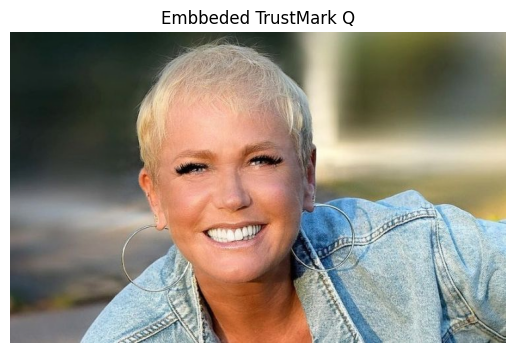

In [ ]:
display_image(image_path2, title="Embbeded TrustMark Q")

In [ ]:

def run_watermark_attack_suite(
    original_watermarked_image_path: str,
    original_cover_image_path: str,
    secret_message: str,
    decoder_instance, # Can be TrustMark, DWT_DCT_Watermark, invisible-watermark decoder
    display_images: bool = False
) -> list:
    """
    Runs a suite of common image processing attacks on a watermarked image
    and evaluates watermark robustness.

    Args:
        original_watermarked_image_path (str): Path to the watermarked image.
        original_cover_image_path (str): Path to the original (unwatermarked) cover image.
                                          Used for comparison metrics or non-blind decoding.
        secret_message (str): The original secret message embedded in the watermark.
        decoder_instance: An instance of the watermarking decoder class
                          (e.g., TrustMark, DWT_DCT_Watermark, invisible-watermark.WatermarkDecoder).
        display_images (bool): If True, attempts to display images after each attack.
                               Requires a display backend (e.g., matplotlib, cv2.imshow).

    Returns:
        list: A list of dictionaries, where each dictionary contains the results
              for a specific attack.
    """
    all_attack_results = []

    # --- Configuration ---
    # The paths and secret are now arguments to the function.

    if not os.path.exists(original_watermarked_image_path):
        print(f"'{original_watermarked_image_path}' não encontrado.")
        print("Por favor, execute o script de embedding para criar a imagem watermarked primeiro.")
        sys.exit(1) # Exit if the necessary watermarked image doesn't exist

    print(f"\nIniciando testes de ataque na imagem: {original_watermarked_image_path}")
    print(f"Segredo Original para verificação: '{secret_message}'")

    if display_images:
        display_image_if_exists(original_watermarked_image_path, "Imagem Original com Marca d'Água")

    # --- Run various attacks ---

    # Resize Attacks
    all_attack_results.append(run_attack_test(
        attack_name = "Redimensionar para 25%", attack_function = attack_resize, input_image_path=ORIGINAL_WATERMARKED_IMAGE_PATH,
        output_image_suffix='_resized_25.png', percentage=25,secret=SECRET_MESSAGE, decoder=decoder,
    ))
    all_attack_results.append(run_attack_test(
        attack_name = "Redimensionar para 50%", attack_function = attack_resize, input_image_path=ORIGINAL_WATERMARKED_IMAGE_PATH,
        output_image_suffix='_resized_50.png', percentage=50, secret=SECRET_MESSAGE, decoder=decoder,
    ))
    all_attack_results.append(run_attack_test(
        attack_name = "Redimensionar para 200%", attack_function =attack_resize, input_image_path=ORIGINAL_WATERMARKED_IMAGE_PATH,
        output_image_suffix='_resized_200.png', percentage=200 ,secret=SECRET_MESSAGE, decoder=decoder,
    ))

    # Rotate Attacks
    all_attack_results.append(run_attack_test(
        attack_name = "Rotacionar 15 graus",attack_function =attack_rotate, input_image_path=ORIGINAL_WATERMARKED_IMAGE_PATH,
        output_image_suffix='_rotated_15.png', angle=15,secret=SECRET_MESSAGE, decoder=decoder,
    ))
    all_attack_results.append(run_attack_test(
        attack_name ="Rotacionar 30 graus", attack_function =attack_rotate, input_image_path=ORIGINAL_WATERMARKED_IMAGE_PATH,
        output_image_suffix='_rotated_30.png', angle=30,secret=SECRET_MESSAGE, decoder=decoder,
    ))

    # Cut/Crop Attacks
    all_attack_results.append(run_attack_test(
        attack_name ="Cortar (Crop) 10% das bordas", attack_function =attack_cut, input_image_path=ORIGINAL_WATERMARKED_IMAGE_PATH,
        output_image_suffix='_cut_15.png', percentage=15,secret=SECRET_MESSAGE, decoder=decoder,
    ))
    all_attack_results.append(run_attack_test(
        attack_name ="Cortar (Crop) 15% das bordas", attack_function =attack_cut, input_image_path=ORIGINAL_WATERMARKED_IMAGE_PATH,
        output_image_suffix='_cut_30.png', percentage=30,secret=SECRET_MESSAGE, decoder=decoder,
    ))

    # Black Border Attack
    all_attack_results.append(run_attack_test(
        attack_name = "Adicionar Borda Preta (10%)", attack_function =attack_black_border,  input_image_path=ORIGINAL_WATERMARKED_IMAGE_PATH,
        output_image_suffix='_black_border_10.png', border_size_percentage=10,secret=SECRET_MESSAGE, decoder=decoder
    ))
    # Color Change Attacks
    all_attack_results.append(run_attack_test(
        attack_name = "Converter para Escala de Cinza", attack_function =attack_change_colors_grayscale,  input_image_path=ORIGINAL_WATERMARKED_IMAGE_PATH,
        output_image_suffix='_grayscale.png',secret=SECRET_MESSAGE, decoder=decoder
    ))
    all_attack_results.append(run_attack_test(
        attack_name ="Inverter Cores", attack_function =attack_change_colors_invert, input_image_path=ORIGINAL_WATERMARKED_IMAGE_PATH,
        output_image_suffix='_inverted_colors.png',secret=SECRET_MESSAGE, decoder=decoder
    ))
    # --- Ataques de Compressão ---
    print("\n--- Iniciando Testes de Ataque de Compressão ---")

    # TIFF (Lossless, using 'tiff_deflate' which is ZIP compression)
    all_attack_results.append(run_attack_test(
         attack_name ="Compressão TIFF (Deflate)", attack_function =attack_compress_tiff,  input_image_path=ORIGINAL_WATERMARKED_IMAGE_PATH,
         output_image_suffix='_tiff_deflate.tiff', compression='tiff_deflate',secret=SECRET_MESSAGE, decoder=decoder
    ))
    # TIFF (Lossless, LZW)
    all_attack_results.append(run_attack_test(
        attack_name ="Compressão TIFF (LZW)", attack_function =attack_compress_tiff, input_image_path=ORIGINAL_WATERMARKED_IMAGE_PATH,
        output_image_suffix='_tiff_lzw.tiff', compression='tiff_lzw',secret=SECRET_MESSAGE, decoder=decoder
    ))

    # JPEG (Lossy)
    all_attack_results.append(run_attack_test(
        attack_name ="Compressão JPEG (Qualidade 90)", attack_function =attack_compress_jpeg, input_image_path=ORIGINAL_WATERMARKED_IMAGE_PATH,
        output_image_suffix='_jpeg_q90.jpg', quality=90,secret=SECRET_MESSAGE, decoder=decoder
    ))
    all_attack_results.append(run_attack_test(
        "Compressão JPEG (Qualidade 70)", attack_compress_jpeg, ORIGINAL_WATERMARKED_IMAGE_PATH,
        output_image_suffix='_jpeg_q70.jpg', quality=70,secret=SECRET_MESSAGE, decoder=decoder
    ))
    all_attack_results.append(run_attack_test(
        "Compressão JPEG (Qualidade 50)", attack_compress_jpeg, ORIGINAL_WATERMARKED_IMAGE_PATH,
        output_image_suffix='_jpeg_q50.jpg', quality=50,secret=SECRET_MESSAGE, decoder=decoder
    ))

    # JPEG2000 (Lossy by rate)
    all_attack_results.append(run_attack_test(
        "Compressão JPEG2000 (Taxa 5:1)", attack_compress_jpeg2000, ORIGINAL_WATERMARKED_IMAGE_PATH,
        output_image_suffix='_jp2_rate5.jp2', quality_mode='rates',secret=SECRET_MESSAGE, decoder=decoder
    ))
    all_attack_results.append(run_attack_test(
        "Compressão JPEG2000 (Taxa 10:1)", attack_compress_jpeg2000, ORIGINAL_WATERMARKED_IMAGE_PATH,
        output_image_suffix='_jp2_rate10.jp2', quality_mode='rates', quality=10,secret=SECRET_MESSAGE, decoder=decoder
    ))
    # --- Summarize Results ---
    print("\n\n=============== Sumário dos Resultados dos Ataques ===============")
    print(f"{'Ataque':<35} | {'Sucesso':<10} | {'WM Presente':<13} | {'Segredo Corresponde':<20} | {'Segredo Extraído':<30}")
    print("-" * 120)

    for result in all_attack_results:
        attack_name = result['attack_name']
        attack_success = "Sim" if result['attack_successful'] else "Não"
        wm_present = "Sim" if result['watermark_present'] else "Não"
        secret_match = "Sim" if result['secret_match'] else "Não"
        detected_secret = result['detected_secret'] if result['detected_secret'] is not None else "N/A"

        # Truncate secret if too long for display
        if detected_secret != "N/A" and len(str(detected_secret)) > 28:
            detected_secret = str(detected_secret)[:25] + "..."

        print(f"{attack_name:<35} | {attack_success:<10} | {wm_present:<13} | {secret_match:<20} | {detected_secret:<30}")

    print("-" * 120)
    print("Fim dos testes de ataque.")



    return all_attack_results


In [ ]:
all_attack_results

[{'attack_name': 'Redimensionar para 25%',
  'attack_successful': True,
  'detected_secret': 'F46248768',
  'secret_match': True,
  'watermark_present': True,
  'name': 'ufo_240_TrustMarked_Q.png'},
 {'attack_name': 'Redimensionar para 50%',
  'attack_successful': True,
  'detected_secret': 'F46248768',
  'secret_match': True,
  'watermark_present': True,
  'name': 'ufo_240_TrustMarked_Q.png'},
 {'attack_name': 'Redimensionar para 200%',
  'attack_successful': True,
  'detected_secret': 'F46248768',
  'secret_match': True,
  'watermark_present': True,
  'name': 'ufo_240_TrustMarked_Q.png'},
 {'attack_name': 'Rotacionar 15 graus',
  'attack_successful': True,
  'detected_secret': '',
  'secret_match': False,
  'watermark_present': False,
  'name': 'ufo_240_TrustMarked_Q.png'},
 {'attack_name': 'Rotacionar 30 graus',
  'attack_successful': True,
  'detected_secret': '',
  'secret_match': False,
  'watermark_present': False,
  'name': 'ufo_240_TrustMarked_Q.png'},
 {'attack_name': 'Cortar

In [ ]:
import sys
decoder = TrustMark(verbose=False, model_type='Q')
ORIGINAL_WATERMARKED_IMAGE_PATH = 'ufo_240_TrustMarked_Q.png'
ORIGINAL_COVER_IMAGE_PATH = image_path1# Needed if TrustMark decode is non-blind or for comparison
SECRET_MESSAGE = Segredo_inicial # The secret you embedded

all_attack_results = run_watermark_attack_suite(
        original_watermarked_image_path=ORIGINAL_WATERMARKED_IMAGE_PATH,
        original_cover_image_path=ORIGINAL_COVER_IMAGE_PATH,
        secret_message=SECRET_MESSAGE,
        decoder_instance=decoder,
        display_images=False # Set to True if you want to see images (requires display setup)
    )


Iniciando testes de ataque na imagem: ufo_240_TrustMarked_Q.png
Segredo Original para verificação: 'F46248768'

===== Testando Ataque: Redimensionar para 25% =====
Imagem atacada salva em: ufo_240_TrustMarked_Q_resized_25.png
--- Tentando decodificar a marca d'água ---
Marca d'água detectada! Segredo extraído: 'F46248768'
>>> Segredo extraído CORRESPONDE ao original. Marca d'água ROBUSTA.

===== Testando Ataque: Redimensionar para 50% =====
Imagem atacada salva em: ufo_240_TrustMarked_Q_resized_50.png
--- Tentando decodificar a marca d'água ---
Marca d'água detectada! Segredo extraído: 'F46248768'
>>> Segredo extraído CORRESPONDE ao original. Marca d'água ROBUSTA.

===== Testando Ataque: Redimensionar para 200% =====
Imagem atacada salva em: ufo_240_TrustMarked_Q_resized_200.png
--- Tentando decodificar a marca d'água ---
Marca d'água detectada! Segredo extraído: 'F46248768'
>>> Segredo extraído CORRESPONDE ao original. Marca d'água ROBUSTA.

===== Testando Ataque: Rotacionar 15 graus

In [ ]:
import torch
import os

print("### ESPECIFICAÇÃO DA MÁQUINA (Google Colab) ###\n")

# --- CPU ---
print("--- Processador (CPU) ---")
# O comando !lscpu mostra detalhes da CPU
# Extrai a linha do nome do modelo para uma saída mais limpa
cpu_info = !lscpu | grep 'Model name'
print(cpu_info[0].strip())
# O comando !nproc mostra o número de núcleos
print(f"Número de núcleos: {os.cpu_count()}\n")

# --- Memória RAM ---
print("--- Memória RAM ---")
# O comando !cat /proc/meminfo mostra detalhes da memória
# Extrai a linha da memória total (MemTotal) e converte para GB
mem_info = !cat /proc/meminfo | grep 'MemTotal'
mem_total_kb = int(mem_info[0].split()[1])
mem_total_gb = mem_total_kb / (1024**2)
print(f"Total: {mem_total_gb:.2f} GB\n")

# --- Placa de Vídeo (GPU) ---
print("--- Placa de Vídeo (GPU) ---")
if torch.cuda.is_available():
    # Obtém o nome da GPU
    gpu_name = torch.cuda.get_device_name(0)
    # Obtém a memória VRAM total da GPU em bytes e converte para GB
    gpu_vram_bytes = torch.cuda.get_device_properties(0).total_memory
    gpu_vram_gb = gpu_vram_bytes / (1024**3)

    print(f"Nome da GPU: {gpu_name}")
    print(f"Total VRAM: {gpu_vram_gb:.2f} GB")
    print(f"Dispositivo em uso: cuda")
else:
    print("GPU não detectada. Dispositivo em uso: cpu\n")

# --- Sistema Operacional ---
print("\n--- Sistema Operacional ---")
# O comando !lsb_release -a mostra os detalhes do SO
!lsb_release -a

print("\n-------------------------------------------")

### ESPECIFICAÇÃO DA MÁQUINA (Google Colab) ###

--- Processador (CPU) ---
Model name:                           Intel(R) Xeon(R) CPU @ 2.20GHz
Número de núcleos: 2

--- Memória RAM ---
Total: 12.67 GB

--- Placa de Vídeo (GPU) ---
GPU não detectada. Dispositivo em uso: cpu


--- Sistema Operacional ---
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.4 LTS
Release:	22.04
Codename:	jammy

-------------------------------------------


In [ ]:
all_attack_results

[{'attack_name': 'Redimensionar para 25%',
  'attack_successful': True,
  'detected_secret': 'F46248768',
  'secret_match': True,
  'watermark_present': True,
  'name': 'ufo_240_TrustMarked_Q.png'},
 {'attack_name': 'Redimensionar para 50%',
  'attack_successful': True,
  'detected_secret': 'F46248768',
  'secret_match': True,
  'watermark_present': True,
  'name': 'ufo_240_TrustMarked_Q.png'},
 {'attack_name': 'Redimensionar para 200%',
  'attack_successful': True,
  'detected_secret': 'F46248768',
  'secret_match': True,
  'watermark_present': True,
  'name': 'ufo_240_TrustMarked_Q.png'},
 {'attack_name': 'Rotacionar 15 graus',
  'attack_successful': True,
  'detected_secret': '',
  'secret_match': False,
  'watermark_present': False,
  'name': 'ufo_240_TrustMarked_Q.png'},
 {'attack_name': 'Rotacionar 30 graus',
  'attack_successful': True,
  'detected_secret': '',
  'secret_match': False,
  'watermark_present': False,
  'name': 'ufo_240_TrustMarked_Q.png'},
 {'attack_name': 'Cortar